In [1]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
project_name='02-insurance-linear-regression'

<IPython.core.display.Javascript object>

In [2]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILEPATH = "~/datasets/insurance.csv"
download_url(DATASET_URL, '~/datasets')

Using downloaded and verified file: /home/khaled/datasets/insurance.csv


In [3]:
dataframe = pd.read_csv(DATA_FILEPATH)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
categorical_cols=['sex','smoker','region']
input_cols = list(dataframe.columns[0:-1])
output_cols = list([dataframe.columns[-1]])

In [6]:
num_rows = len(dataframe)
val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
batch_size = 32



In [7]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array


inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()
dataset = TensorDataset(inputs, targets)



train_ds, val_ds = random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


In [8]:
#verify data prep is correct
for xb, yb in train_loader:
    print("inputs:", xb, "len: ", len(xb))
    print("targets:", yb, "len: ",len(yb))
    break


inputs: tensor([[19.0000,  0.0000, 29.8000,  0.0000,  0.0000,  3.0000],
        [60.0000,  0.0000, 28.7000,  1.0000,  0.0000,  3.0000],
        [32.0000,  1.0000, 33.6300,  1.0000,  1.0000,  0.0000],
        [61.0000,  1.0000, 33.5350,  0.0000,  0.0000,  0.0000],
        [20.0000,  0.0000, 21.8000,  0.0000,  1.0000,  3.0000],
        [50.0000,  0.0000, 30.1150,  1.0000,  0.0000,  1.0000],
        [49.0000,  1.0000, 36.8500,  0.0000,  0.0000,  2.0000],
        [33.0000,  1.0000, 30.2500,  0.0000,  0.0000,  2.0000],
        [43.0000,  0.0000, 32.5600,  3.0000,  1.0000,  2.0000],
        [27.0000,  0.0000, 32.3950,  1.0000,  0.0000,  0.0000],
        [31.0000,  0.0000, 25.8000,  2.0000,  0.0000,  3.0000],
        [18.0000,  1.0000, 23.0850,  0.0000,  0.0000,  0.0000],
        [18.0000,  0.0000, 36.8500,  0.0000,  1.0000,  2.0000],
        [48.0000,  0.0000, 28.8800,  1.0000,  0.0000,  1.0000],
        [35.0000,  1.0000, 24.1300,  1.0000,  0.0000,  1.0000],
        [46.0000,  1.0000, 38.17

In [9]:
import torch.nn 
import torch.nn.functional as F

input_size = len(input_cols)
output_size = len(output_cols)

class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.mse_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

            
            
            
model = InsuranceModel()
list(model.parameters())


[Parameter containing:
 tensor([[ 0.2837,  0.3896,  0.3725,  0.3933, -0.3405,  0.1960]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1948], requires_grad=True)]

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            inputs, targets = batch
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history


In [11]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)


{'val_loss': 304040864.0}


In [12]:
history = fit(10000, 1e-5, model, train_loader, val_loader)


Epoch [100], val_loss: 123027880.0000
Epoch [200], val_loss: 121043328.0000
Epoch [300], val_loss: 119309096.0000
Epoch [400], val_loss: 117799768.0000
Epoch [500], val_loss: 116218768.0000
Epoch [600], val_loss: 114475376.0000
Epoch [700], val_loss: 113269792.0000
Epoch [800], val_loss: 111497200.0000
Epoch [900], val_loss: 110202832.0000
Epoch [1000], val_loss: 108760160.0000
Epoch [1100], val_loss: 107432952.0000
Epoch [1200], val_loss: 106093632.0000
Epoch [1300], val_loss: 104948832.0000
Epoch [1400], val_loss: 103481504.0000
Epoch [1500], val_loss: 102250744.0000
Epoch [1600], val_loss: 101165344.0000
Epoch [1700], val_loss: 100017824.0000
Epoch [1800], val_loss: 98820440.0000
Epoch [1900], val_loss: 97557600.0000
Epoch [2000], val_loss: 96498240.0000
Epoch [2100], val_loss: 95426248.0000
Epoch [2200], val_loss: 94403528.0000
Epoch [2300], val_loss: 93351984.0000
Epoch [2400], val_loss: 92269480.0000
Epoch [2500], val_loss: 91210776.0000
Epoch [2600], val_loss: 90334960.0000
Epoc

Epoch [21400], val_loss: 44615428.0000
Epoch [21500], val_loss: 44643820.0000
Epoch [21600], val_loss: 44475952.0000
Epoch [21700], val_loss: 44412868.0000
Epoch [21800], val_loss: 44752552.0000
Epoch [21900], val_loss: 44628628.0000
Epoch [22000], val_loss: 44483124.0000
Epoch [22100], val_loss: 44366372.0000
Epoch [22200], val_loss: 44476388.0000
Epoch [22300], val_loss: 44574744.0000
Epoch [22400], val_loss: 44358384.0000
Epoch [22500], val_loss: 44354448.0000
Epoch [22600], val_loss: 44364664.0000
Epoch [22700], val_loss: 44236964.0000
Epoch [22800], val_loss: 44406896.0000
Epoch [22900], val_loss: 44536976.0000
Epoch [23000], val_loss: 44242316.0000
Epoch [23100], val_loss: 44413688.0000
Epoch [23200], val_loss: 44215792.0000
Epoch [23300], val_loss: 44305812.0000
Epoch [23400], val_loss: 44105532.0000
Epoch [23500], val_loss: 44320700.0000
Epoch [23600], val_loss: 44141008.0000
Epoch [23700], val_loss: 44045708.0000
Epoch [23800], val_loss: 44267632.0000
Epoch [23900], val_loss: 

Epoch [42500], val_loss: 42368120.0000
Epoch [42600], val_loss: 42296360.0000
Epoch [42700], val_loss: 42472900.0000
Epoch [42800], val_loss: 42464900.0000
Epoch [42900], val_loss: 42368832.0000
Epoch [43000], val_loss: 42238912.0000
Epoch [43100], val_loss: 42188124.0000
Epoch [43200], val_loss: 42581456.0000
Epoch [43300], val_loss: 42054036.0000
Epoch [43400], val_loss: 42375360.0000
Epoch [43500], val_loss: 42426544.0000
Epoch [43600], val_loss: 42088416.0000
Epoch [43700], val_loss: 42342620.0000
Epoch [43800], val_loss: 42518320.0000
Epoch [43900], val_loss: 42239924.0000
Epoch [44000], val_loss: 42218864.0000
Epoch [44100], val_loss: 42260560.0000
Epoch [44200], val_loss: 42421852.0000
Epoch [44300], val_loss: 42548688.0000
Epoch [44400], val_loss: 42405220.0000
Epoch [44500], val_loss: 42622264.0000
Epoch [44600], val_loss: 42258864.0000
Epoch [44700], val_loss: 42188856.0000
Epoch [44800], val_loss: 42263240.0000
Epoch [44900], val_loss: 42288980.0000
Epoch [45000], val_loss: 

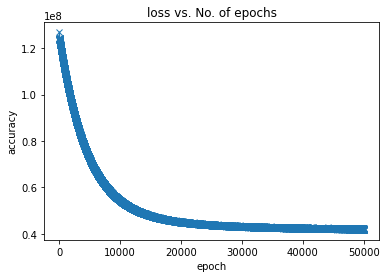

In [16]:
accuracies = [result['val_loss'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('loss vs. No. of epochs');
